In [1]:
import os
import json
import random
import numpy as np
import pandas as pd

from datetime import date
from joblib import dump, load

from tcc_traffic_analysis.testing import TestingPipeline
from tcc_traffic_analysis.custom_algorithms import CustomAlgorithm
from tcc_traffic_analysis.custom_algorithms import ManualFeatureSelection
from tcc_traffic_analysis.classification import ClassificationPipeline
from tcc_traffic_analysis.datasets import CustomDataSet

from tcc_traffic_analysis.classification import run_classifiers

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt
from sklearn import tree

from scipy.stats import ttest_ind
from scipy import stats

In [2]:
def device_class_tor_non_tor_transform(dataset, column_name, rows=None):
    # Iot 1, Non Iot 0
    if rows is not None:
        return dataset[column_name].apply(lambda x: 0 if x in ["Non Tor", "Mobile"] else 1).iloc[rows]
    else:
        return dataset[column_name].apply(lambda x: 0 if x in ["Non Tor", "Mobile"] else 1)

In [3]:
def device_class_anom_transform(dataset, column_name, rows=None):
    # Benigno 0, Anomalia 1
    if rows is not None:
        return dataset[column_name].apply(lambda x: 0 if "Anomaly" not in x else 1).iloc[rows]
    else:
        return dataset[column_name].apply(lambda x: 0 if "Anomaly" not in x else 1) 

In [4]:
def no_transform_x(dataset, column_name, rows=None):
    if rows is not None:
        return dataset.drop([column_name], axis=1).iloc[rows]
    else:
        return dataset.drop([column_name], axis=1).iloc[:]

In [5]:
def no_transform_y(dataset, column_name, rows=None):
    if rows is not None:
        return dataset[column_name].iloc[rows]
    else:
        return dataset[column_name]

In [6]:
def get_f1_scores(files, clf):
    result = []
    for file in files:
        ds = CustomDataSet(None, file, x_function=no_transform_x, y_function=device_class_tor_non_tor_transform)
        predictions = clf.predict(ds.x())
        f1_test = f1_score(ds.y(), predictions, average='binary')
        result.append(f1_test)
    return result

In [7]:
def get_scores(file, clf, y_function=device_class_tor_non_tor_transform):
    ds = CustomDataSet(None, file, x_function=no_transform_x, y_function=y_function)
    predictions = clf.predict(ds.x())
    acc_test = accuracy_score(ds.y(), predictions)
    f1_test = f1_score(ds.y(), predictions, average='binary')
    return [acc_test, f1_test]

In [8]:
class CustomDataSet:
    def __init__(self, name, dataset_file, test_size=0.3, 
                 class_column_name="Device Class", random_state=42, x_function=no_transform_x, y_function=no_transform_y, debug=False):
        self.name = name # Nome para aparecer no arquivo de resultados
        self.dataset = pd.read_csv(dataset_file) # proprio dataset
        self.return_x = x_function # funçao que retornara o x do dataset
        self.return_y = y_function # funçao que retornara a classo do dataset
        self.class_column = class_column_name # nome da coluna de class
        self.test_size = test_size # porcentagem que sera separada para teste
        self.random_state = random_state 
        self.debug = debug
        self.train_test_split()
        if self.debug:
            self.na_values()
            
    def na_values(self):
        print(self.name)
        aux_nan = (self.dataset.isna().sum()).sort_values()
        for column in self.dataset.columns:
            try:
                aux_inf = np.isinf(self.dataset[column]).values.sum()
                if aux_inf > 0:
                    print("inf:", column, aux_inf)
            except:
                print(column, "fail inf")
        print(aux_nan[lambda x: x > 0])
            
    # The ideai behind this function is to keep the transformation function
    def replace_dataset_df(self, new_name, new_file, test_size=0.3, class_column_name="Device Class", random_state=42):
        self.name = new_name
        self.dataset = pd.read_csv(new_file) # proprio dataset
        self.test_size = test_size
        self.train_test_split()
            
    def train_test_split(self):
        x_train, x_test, y_train, y_test = train_test_split(self.x(), self.y(), test_size=self.test_size)
        self.train_indexes = y_train.index.values.tolist()
        self.test_indexes = y_test.index.values.tolist()
        
    def device(self):
        return self.dataset["Device Class"]
        
    def x(self, train=False, test=False):
        if train:
            return self.return_x(self.dataset, self.class_column, rows=self.train_indexes)
        if test:
            return self.return_x(self.dataset, self.class_column, rows=self.test_indexes)
        return self.return_x(self.dataset, self.class_column)
    
    def y(self, train=False, test=False):
        if train:
            return self.return_y(self.dataset, self.class_column, rows=self.train_indexes)
        if test:
            return self.return_y(self.dataset, self.class_column, rows=self.test_indexes)
        return self.return_y(self.dataset, self.class_column)


In [9]:
def find_lines_in_common(df1, df2):
    duplicates_1 = df1[df1.duplicated()].shape[0]/df1.shape[0]
    duplicates_2 = df2[df2.duplicated()].shape[0]/df2.shape[0]

    df = pd.concat([df1, df2])
    duplicates_merge = df[df.duplicated()].shape[0]/df1.shape[0]
    return [duplicates_1, duplicates_2, duplicates_merge]

In [10]:
def atribui_label_1(dataset_nome):
    if "05_05_05" in dataset_nome:
        return 1
    if "05_10_00" in dataset_nome:
        return 2
    if "05_00_10" in dataset_nome:
        return 3

In [11]:
def atribui_label_2(dataset_nome):
    return dataset_nome.split("_")[0].replace("-", " ").title()

In [12]:
def atribui_label_3(dataset_nome):
    return "Benignos e Anômalos"

In [13]:
def get_models(dir_path, filter_string):
    models = [dir_path + file for file in os.listdir(dir_path) if filter_string in file]
    models.sort()
    return models

In [14]:
def get_selected_columns(pipeline):
    df_columns = pd.read_csv('./datasets/experimento-1/iot-mobile/05_10_00-90-test.csv').drop(["Device Class"], axis=1).columns
    sel_index = pipeline['FSele'].get_support()
    return df_columns[sel_index]

In [15]:
def filter_cols_not_zero(df):
    serie = df.iloc[:, 1:].sum() 
    return serie[serie > 0].index.values.tolist()

In [16]:
def create_scorers():
    scorers = {'accuracy_score': make_scorer(accuracy_score),
               'precision_score': make_scorer(precision_score, average='micro'),
               'f1_score': make_scorer(f1_score, average='micro'),
               'recall_score': make_scorer(recall_score, average='micro')}
    return scorers

In [17]:
def replace_values(df, column, old_value, new_value):
    df[column] = np.where(df[column] == old_value, new_value, df[column])

In [18]:
def teste_hipotese(array_1, array_2, hipotese, significancia=0.05):
    ttest, pval = stats.ttest_rel(array_1, array_2)
    if pval < significancia:
        print(hipotese + ", rejeitamos hipotese nula")
    else:
        print(hipotese + ", falhamos em rejeitar a hipotese nula")

In [19]:
class CustomAlgorithm:
    def __init__(self, name, algorithm):
        self.name = name
        self.algorithm = algorithm
        
class ManualFeatureSelection:
    def __init__(self):
        self.columns_to_keep = [
            'Src Port', 'Down/Up Ratio', 'Active Min','Active Std', 
            'Bwd Packet Length Max', 'ACK Flag Count', 'Fwd IAT Std', 
            'PSH Flag Count', 'Fwd IAT Mean'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns_to_keep].values

In [20]:
file_1 = './resultados/only-ng-base.csv'
file_2 = './resultados/only-ng-nrm.csv'

In [26]:
df = pd.read_csv(file_1)

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

df.groupby(['algoritmo', 'teste']).mean()[["acuracia", "f1"]].round(decimals=5)

acuracia       f1
algoritmo teste                              
GNB       Appliences         0.82142  0.78259
          Cameras            0.77562  0.71070
          Controller Hubs    0.84315  0.81397
          Energy Managment   0.88022  0.86391
          Health Monitor     0.83360  0.80037

In [24]:
df = pd.read_csv(file_2)

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

df = df[(df["treino"] == df["teste"])]
df.groupby(['algoritmo', 'treino']).mean()[["acuracia", "f1"]].round(decimals=5)

acuracia       f1
algoritmo treino                             
GNB       Appliences         0.82142  0.78259
          Cameras            0.77562  0.71070
          Controller Hubs    0.84315  0.81397
          Energy Managment   0.88022  0.86391
          Health Monitor     0.83360  0.80037

In [99]:
df = pd.read_csv("./resultados/experimento-2/resultado_experimento_2_base_hip-100-26-07-2021.csv")

df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')

replace_values(df, 'treino', 1, 'TC 1')
replace_values(df, 'treino', '2', 'TC 2')
replace_values(df, 'treino', '3', 'TC 3')

df.groupby(by=['algoritmo', 'teste'], sort=True).mean()[["acuracia", "f1"]].round(decimals=5)#.to_latex('resultado-1.table')

acuracia       f1
algoritmo teste                              
GNB       Appliences         0.82149  0.78268
          Cameras            0.77734  0.71355
          Controller Hubs    0.84195  0.81227
          Energy Managment   0.88300  0.86750
          Health Monitor     0.83464  0.80187

In [100]:
df = pd.read_csv("./resultados/experimento-2/resultado_experimento_2-100-25-07-2021.csv")

df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')

replace_values(df, 'treino', 1, 'TC 1')
replace_values(df, 'treino', '2', 'TC 2')
replace_values(df, 'treino', '3', 'TC 3')

df.groupby(by=['algoritmo', 'treino'], sort=True).mean()[["acuracia", "f1"]].round(decimals=5)#.to_latex('resultado-1.table')

acuracia       f1
algoritmo treino                             
GNB       Appliences         0.82149  0.78268
          Cameras            0.79941  0.74812
          Controller Hubs    0.81359  0.76950
          Energy Managment   0.83094  0.79400
          Health Monitor     0.83168  0.79557

# Tabelas p/ ICTAI

In [26]:
files = [file for file in os.listdir("./resultados") if ".csv" in file]
files

['full_result_experiment_two.csv']

### Cenario 1

In [41]:
exp_1_files = [file for file in os.listdir("./resultados") if "experimento_1" in file]

In [51]:
df = pd.DataFrame()
for file in exp_1_files:
    df = pd.concat([pd.read_csv("./resultados/" + file), df])

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_1)
df["teste"] = df["dataset_test"].apply(atribui_label_1)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

replace_values(df, 'treino', 1, 'TC 1')
replace_values(df, 'treino', '2', 'TC 2')
replace_values(df, 'treino', '3', 'TC 3')

df = df[df["algoritmo"] != "GNB"]

In [52]:
pd.set_option('display.max_rows', 100)
df.groupby(by=['algoritmo', 'treino'], sort=True).mean()[["acuracia", "f1"]].round(decimals=5)#.to_latex('resultado-1.table')

acuracia       f1
algoritmo treino                   
ADA       TC 1     0.97434  0.97442
          TC 2     0.90862  0.91670
          TC 3     0.91822  0.92681
DT        TC 1     0.99085  0.99087
          TC 2     0.92498  0.93180
          TC 3     0.95415  0.95717
GB        TC 1     0.98631  0.98629
          TC 2     0.93080  0.93635
          TC 3     0.93108  0.93752
KNN       TC 1     0.88922  0.89028
          TC 2     0.81820  0.83365
          TC 3     0.79467  0.82791
LDA       TC 1     0.78375  0.79863
          TC 2     0.77815  0.80893
          TC 3     0.74780  0.77733
MLP       TC 1     0.87202  0.87482
          TC 2     0.79252  0.80106
          TC 3     0.78501  0.81736
QDA       TC 1     0.77961  0.74982
          TC 2     0.59096  0.56082
          TC 3     0.76669  0.71583
RF        TC 1     0.99383  0.99383
          TC 2     0.93124  0.93730
          TC 3     0.94110  0.94629
XGB       TC 1     0.99493  0.99494
          TC 2     0.92812  0.93492
          TC 3     0.94355  0.94826

### Cenario 2

In [20]:
exp_2_files = [file for file in files if "experimento_2" in file]

NameError: name 'files' is not defined

In [58]:
df = pd.DataFrame()
for file in exp_2_files:
    df = pd.concat([pd.read_csv("./resultados/" + file), df])


df = df[df["algoritmo"] != "Gaussian Naive Bayes"]
df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

In [62]:
df1 = df[(df["treino"] == df["teste"])]
df1.groupby(['algoritmo', 'treino']).mean()[["acuracia", "f1"]].round(decimals=5).to_latex('resultado-2.table')

In [63]:
df2 = df[(df["treino"] == "All Iot")]
df2.groupby(['algoritmo', 'teste']).mean()[["acuracia", "f1"]].round(decimals=5).to_latex('resultado-22.table')

# Teste Hipótese p/ ICTAI

### Cenario 1

In [64]:
df = pd.DataFrame()
for file in exp_1_files:
    df = pd.concat([pd.read_csv("./resultados/" + file), df])

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_1)
df["teste"] = df["dataset_test"].apply(atribui_label_1)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

replace_values(df, 'treino', 1, 'TC 1')
replace_values(df, 'treino', '2', 'TC 2')
replace_values(df, 'treino', '3', 'TC 3')

df["algoritmo"].value_counts()

GB     225
LDA    225
DT     225
XGB    225
RF     225
MLP    225
KNN    225
GNB    225
ADA    225
QDA    225
Name: algoritmo, dtype: int64

In [65]:
f1_1 = df[df["treino"] == 'TC 1']["acuracia"].values
f1_2 = df[df["treino"] == 'TC 2']["acuracia"].values
f1_3 = df[df["treino"] == 'TC 3']["acuracia"].values

In [66]:
teste_hipotese(f1_1, f1_2, "iot mobile")
teste_hipotese(f1_1, f1_3, "iot normal")

iot mobile, rejeitamos hipotese nula
iot normal, rejeitamos hipotese nula


In [67]:
df = df[df["algoritmo"] != "GNB"]
df["algoritmo"].value_counts()

GB     225
LDA    225
DT     225
XGB    225
RF     225
MLP    225
KNN    225
ADA    225
QDA    225
Name: algoritmo, dtype: int64

In [68]:
f1_1 = df[df["treino"] == 'TC 1']["acuracia"].values
f1_2 = df[df["treino"] == 'TC 2']["acuracia"].values
f1_3 = df[df["treino"] == 'TC 3']["acuracia"].values

In [69]:
teste_hipotese(f1_1, f1_2, "iot mobile")
teste_hipotese(f1_1, f1_3, "iot normal")

iot mobile, rejeitamos hipotese nula
iot normal, rejeitamos hipotese nula


### Cenario 2

In [70]:
df = pd.read_csv("./resultados/full_result_experiment_two.csv")

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

df["algoritmo"].value_counts()

LDA    750
RF     750
MLP    750
KNN    750
ADA    750
DT     750
GB     750
XGB    750
GNB    750
QDA    750
Name: algoritmo, dtype: int64

In [71]:
df_base = df[df['treino'] == 'All Iot']
df_test = df[df['treino'] != 'All Iot']

for iot_class in df_test['treino'].unique().tolist():
    f1_1 = df_base[df_base["teste"]  == iot_class]["acuracia"].values
    f1_2 = df_test[(df_test["treino"] == iot_class) & (df_test["teste"]  == iot_class)]["acuracia"].values
    teste_hipotese(f1_1, f1_2, iot_class)

Appliences, rejeitamos hipotese nula
Cameras, rejeitamos hipotese nula
Controller Hubs, rejeitamos hipotese nula
Energy Managment, falhamos em rejeitar a hipotese nula
Health Monitor, falhamos em rejeitar a hipotese nula


In [72]:
df = df[df["algoritmo"] != "GNB"]
df["algoritmo"].value_counts()

LDA    750
RF     750
MLP    750
KNN    750
ADA    750
DT     750
GB     750
XGB    750
QDA    750
Name: algoritmo, dtype: int64

In [73]:
df_base = df[df['treino'] == 'All Iot']
df_test = df[df['treino'] != 'All Iot']

for iot_class in df_test['treino'].unique().tolist():
    f1_1 = df_base[df_base["teste"]  == iot_class]["acuracia"].values
    f1_2 = df_test[(df_test["treino"] == iot_class) & (df_test["teste"]  == iot_class)]["acuracia"].values
    teste_hipotese(f1_1, f1_2, iot_class)

Appliences, rejeitamos hipotese nula
Cameras, rejeitamos hipotese nula
Controller Hubs, rejeitamos hipotese nula
Energy Managment, falhamos em rejeitar a hipotese nula
Health Monitor, falhamos em rejeitar a hipotese nula


# ALIFJDALFD

In [88]:
df = pd.read_csv("./resultados/full_result_experiment_two.csv")

df = df[df["train_method"] == "Grid Search 3 folds"]
df = df[df["selecao_feat"] == "Tree"]
df["treino"] = df["dataset_treino"].apply(atribui_label_2)
df["teste"] = df["dataset_test"].apply(atribui_label_2)
df = df[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

replace_values(df, 'algoritmo', 'Ada Boosting', 'ADA')
replace_values(df, 'algoritmo', 'Decision Trees', 'DT')
replace_values(df, 'algoritmo', 'Gaussian Naive Bayes', 'GNB')
replace_values(df, 'algoritmo', 'Gradient Boosting', 'GB')
replace_values(df, 'algoritmo', 'Knn', 'KNN')
replace_values(df, 'algoritmo', 'Linear Discriminant Analysis', 'LDA')
replace_values(df, 'algoritmo', 'Quadratic Discriminant Analysis ', 'QDA')
replace_values(df, 'algoritmo', 'Random Forests', 'RF')
replace_values(df, 'algoritmo', 'XGBoost', 'XGB')

df_base = df[df['treino'] == 'All Iot']
df_test = df[df['treino'] != 'All Iot']

In [89]:
df_base[df_base["algoritmo"] == "GNB"].groupby(['algoritmo', 'teste']).mean()[["acuracia", "f1"]].round(decimals=5)

acuracia       f1
algoritmo teste                              
GNB       Appliences         0.69443  0.55525
          Cameras            0.66649  0.51727
          Controller Hubs    0.71581  0.60849
          Energy Managment   0.72175  0.57946
          Health Monitor     0.69375  0.53531

In [90]:
df_test[df_test["algoritmo"] == "GNB"].groupby(['algoritmo', 'teste']).mean()[["acuracia", "f1"]].round(decimals=5)

acuracia       f1
algoritmo teste                              
GNB       Appliences         0.69270  0.55235
          Cameras            0.66627  0.51574
          Controller Hubs    0.71610  0.60765
          Energy Managment   0.72016  0.57662
          Health Monitor     0.69308  0.53338

# Gerar Tabelas

In [114]:
resul_exp_1 = './resultados/experimento-1/resultado_experimento_1-90-22-05-2021.csv'
resul_exp_2 = './resultados/experimento-2/resultado_experimento_2-90-23-05-2021.csv'
resul_exp_3 = './resultados/experimento-extra/resultado_experimento_extra-90-23-05-2021.csv'

# Experimento 1

In [60]:
df_1 = pd.read_csv(resul_exp_1)

df_1 = df_1[df_1["train_method"] == "Grid Search 3 folds"]
df_1 = df_1[df_1["selecao_feat"] == "Tree"]
df_1["treino"] = df_1["dataset_treino"].apply(atribui_label_1)
df_1["teste"] = df_1["dataset_test"].apply(atribui_label_1)
df_1 = df_1[["algoritmo", "treino", "teste", "acuracia", "precisao", "recall", "f1"]]

In [61]:
df_1.groupby(['algoritmo', 'treino', 'teste']).mean()[["f1", "acuracia"]].round(decimals=3).to_latex('resultado-1.table')
df_1.groupby(['algoritmo', 'treino', 'teste']).mean()[["f1", "acuracia"]].round(decimals=3)

In [66]:
models = get_models('./models/tcc/naive-bayes/used/', "tree_05")
for model in models:
    clf = load(model)
    sel_columns = get_selected_columns(clf)
    df = pd.concat([
        pd.DataFrame(clf['Class'].sigma_, columns=sel_columns),
        pd.DataFrame(clf['Class'].theta_, columns=sel_columns)
    ])
    df['Tipo'] = ["Sigma 0", "Sigma 1", "Theta 0", "Theta 1"]
    print(model)
    print(df)

./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-90-train.sck
       Src Port      Dst Port      Protocol  Flow Duration  \
0  5.536029e+08  4.543374e+08  2.045605e+06   2.540514e+15   
1  3.452338e+08  5.401924e+08  2.045591e+06   1.439262e+15   
0  2.771441e+04  1.596211e+04  9.781636e+00   3.655163e+07   
1  3.850346e+04  2.128074e+04  8.671000e+00   2.162774e+07   

   Fwd Packet Length Max  Bwd Packet Length Max  Bwd Packet Length Min  \
0           2.121793e+06           2.163144e+06           2.052353e+06   
1           2.217984e+06           2.259624e+06           2.045878e+06   
0           1.387987e+02           1.546195e+02           3.319082e+01   
1           2.283092e+02           2.186722e+02           6.844818e+00   

   Flow Packets/s  Fwd IAT Total  Fwd Header Length  ...  Packet Length Max  \
0    1.451714e+07   2.528070e+15       4.392517e+06  ...       2.206010e+06   
1    2.351113e+09   1.407996e+15       2.128936e+08  ...      

# Experimento 2

In [27]:
df_2 = pd.read_csv(resul_exp_2)

df_2 = df_2[df_2["train_method"] == "Grid Search 3 folds"]
df_2 = df_2[df_2["selecao_feat"] == "Tree"]
df_2["Classe IoT"] = df_2["dataset_treino"].apply(atribui_label_2)
df_2 = df_2[["algoritmo", "Classe IoT", "acuracia", "precisao", "recall", "f1"]]

In [39]:
df_2["Algoritmo"] = "xXx".join(df_2["algoritmo"].values.tolist()).replace('Gaussian Naive Bayes', "\textit{Gaussian Naive Bayes}").replace("Decision Trees", "árvores de decisão").replace("Knn", "KNN").replace("Random Forests", "florestas aleatórias").split("xXx")
df_2["Média \textit{F1-score}"] = df_2["f1"]
df_2["Média Acurácia"]

In [41]:
df_2.groupby(['Algoritmo', 'Classe IoT']).mean()[["Média \textit{F1-score}", "Média Acurácia"]].round(decimals=3).to_latex('resultado-2.table')
df_2.groupby(['Algoritmo', 'Classe IoT']).mean()[["Média \textit{F1-score}", "Média Acurácia"]].round(decimals=3)

Média \textit{F1-score}  \
Algoritmo                     Classe IoT                                  
\textit{Gaussian Naive Bayes} Appliences                          0.783   
                              Cameras                             0.711   
                              Controller Hubs                     0.814   
                              Energy Managment                    0.864   
                              Health Monitor                      0.800   
KNN                           Appliences                          0.859   
                              Cameras                             0.785   
                              Controller Hubs                     0.852   
                              Energy Managment                    0.946   
                              Health Monitor                      0.909   
florestas aleatórias          Appliences                          1.000   
                              Cameras                             1.000   
                              Controller Hubs                     1.000   
                              Energy Managment                    1.000   
                              Health Monitor                      1.000   
árvores de decisão            Appliences                          1.000   
                              Cameras                             1.000   
                              Controller Hubs                     1.000   
                              Energy Managment                    1.000   
                              Health Monitor                      1.000   

                                                Média Acurácia  
Algoritmo                     Classe IoT                        
\textit{Gaussian Naive Bayes} Appliences                 0.821  
                              Cameras                    0.776  
                              Controller Hubs            0.843  
                              Energy Managment           0.880  
                              Health Monitor             0.834  
KNN                           Appliences                 0.875  
                              Cameras                    0.815  
                              Controller Hubs            0.867  
                              Energy Managment           0.948  
                              Health Monitor             0.918  
florestas aleatórias          Appliences                 1.000  
                              Cameras                    1.000  
                              Controller Hubs            1.000  
                              Energy Managment           1.000  
                              Health Monitor             1.000  
árvores de decisão            Appliences                 1.000  
                              Cameras                    1.000  
                              Controller Hubs            1.000  
                              Energy Managment           1.000  
                              Health Monitor             1.000

## Comparando modelos exp 1 e 2

In [43]:
model_path = './models/tcc/'
model_std = 'tree_05_05_05'

dirs = [model_path + x + "/used/" for x in os.listdir(model_path) if '.' not in x]
models = []

for diretorio in dirs:
    models += get_models(diretorio, model_std)

models

['./models/tcc/knn/used/knn_grid_search_3_folds_tree_05_05_05-90-train.sck',
 './models/tcc/knn/used/knn_grid_search_3_folds_tree_05_05_05-91-train.sck',
 './models/tcc/knn/used/knn_grid_search_3_folds_tree_05_05_05-92-train.sck',
 './models/tcc/knn/used/knn_grid_search_3_folds_tree_05_05_05-93-train.sck',
 './models/tcc/knn/used/knn_grid_search_3_folds_tree_05_05_05-94-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-90-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-91-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-92-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-93-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-94-train.sck',
 './models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_05_05_05-90-train.sck',
 './mod

In [37]:
test_path = './datasets/experimento-2/'
classes = ['appliences', 'cameras', 'controller_hubs', 'energy_managment', 'health_monitor']
file_ext = '-test.csv'
test_files = []
df_final = {
    'Algoritmo': [],
    'Teste': [],
    'F1-score': [],
    'Acuracia': []
}

for classe in classes:
    diretorio = test_path + classe
    test_files += [diretorio + '/' + x for x in os.listdir(diretorio) if file_ext in x]

for model in models:
    clf = load(model)
    for test in test_files:
        acc, f1 = get_scores(test, clf)
        df_final['Algoritmo'].append(model.split('/')[3])
        df_final['Teste'].append(test.split('/')[4].split('_')[0])
        df_final['F1-score'].append(f1)
        df_final['Acuracia'].append(acc)
        
aux_df = pd.DataFrame(df_final)

In [38]:
aux_df.groupby(['Algoritmo', 'Teste']).mean()[["F1-score", "Acuracia"]].round(decimals=3)

F1-score  Acuracia
Algoritmo      Teste                               
decision-tree  appliences           0.000     0.493
               cameras              0.000     0.493
               controller-hubs      0.000     0.493
               energy-managment     0.000     0.493
               health-monitor       0.000     0.493
knn            appliences           0.619     0.615
               cameras              0.460     0.505
               controller-hubs      0.469     0.511
               energy-managment     0.279     0.411
               health-monitor       0.273     0.406
naive-bayes    appliences           0.636     0.562
               cameras              0.523     0.472
               controller-hubs      0.550     0.492
               energy-managment     0.567     0.506
               health-monitor       0.585     0.519
random-forests appliences           0.070     0.513
               cameras              0.005     0.492
               controller-hubs      0.006     0.492
               energy-managment     0.043     0.504
               health-monitor       0.035     0.501

In [135]:
classes = ['appliences', 'cameras', 'controller-hubs', 'energy-managment', 'health-monitor']
model_path = './models/tcc/'
model_std = 'tree_05_05_05'
dirs = [model_path + 'naive-bayes/used/']

exp_1_models = []
exp_2_models = []

for diretorio in dirs:
    exp_1_models += get_models(diretorio, model_std)
    
for diretorio in dirs:
    for classe in classes:
        exp_2_models += get_models(diretorio, classe)

In [136]:
result_frame = {
    'Experimento': []
}
colunas = pd.read_csv("./datasets/experimento-1/iot-mobile-nontor/05_05_05-90-train.csv").columns.values.tolist()
colunas.sort()
for coluna in colunas:
    result_frame[coluna] = []

for model_1 in exp_1_models:
    clf = load(model_1)
    sel_cols = get_selected_columns(clf)
    result_frame['Experimento'].append("1")
    colunas_selecionadas = get_selected_columns(clf)
    colunas_selecionadas.sort_values()
    for coluna in result_frame.keys():
        if coluna in colunas_selecionadas:
            result_frame[coluna].append(1)
        elif coluna != 'Experimento':
            result_frame[coluna].append(0)

for model_2 in exp_2_models:
    clf = load(model_2)
    sel_cols = get_selected_columns(clf)
    result_frame['Experimento'].append("2")
    colunas_selecionadas = get_selected_columns(clf)
    colunas_selecionadas.sort_values()
    for coluna in result_frame.keys():
        if coluna in colunas_selecionadas:
            result_frame[coluna].append(1)
        elif coluna != 'Experimento':
            result_frame[coluna].append(0)
            
aux = pd.DataFrame(result_frame)

In [138]:
#aux.to_csv('select_cols.csv')
not_zero = filter_cols_not_zero(aux)
not_zero.insert(0, "Experimento")
aux[not_zero]

,Experimento,ACK Flag Count,Active Min,Active Std,Average Packet Size,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Total,Bwd Init Win Bytes,Bwd Packet Length Max,...,Fwd IAT Total,Fwd Packets/s,Fwd Seg Size Min,PSH Flag Count,Packet Length Max,Packet Length Std,Packet Length Variance,Protocol,SYN Flag Count,Src Port
0,1,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,1,0,1,1,1
1,1,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,1,1,1,1,1
2,1,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,1,0,1,1,1
3,1,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,1,0,1,0,1
4,1,0,0,0,0,0,0,0,1,0,...,1,1,1,0,1,1,0,1,0,1
5,2,1,1,1,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,1
6,2,1,1,1,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,1,1
7,2,1,1,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,1
8,2,1,1,1,0,0,0,0,0,1,...,1,0,1,1,0,0,0,0,0,1
9,2,1,1,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [139]:
aux_1 = aux[aux["Experimento"] == "1"]
aux_1[filter_cols_not_zero(aux_1)].sum().sort_values(ascending=False)

Src Port                  5
Fwd Header Length         5
Bwd Packet Length Min     5
Bwd Packets/s             5
Dst Port                  5
FWD Init Win Bytes        5
Flow Duration             5
Flow IAT Min              5
Flow Packets/s            5
Fwd IAT Total             5
Fwd Packets/s             5
Fwd Seg Size Min          5
Packet Length Max         5
Packet Length Std         5
Protocol                  5
Bwd Init Win Bytes        5
Flow IAT Max              4
SYN Flag Count            3
Flow IAT Mean             3
Bwd Segment Size Avg      2
Packet Length Variance    1
dtype: int64

In [140]:
aux_2 = aux[aux["Experimento"] == "2"]
aux_2[filter_cols_not_zero(aux_2)].sum().sort_values(ascending=False)

Src Port                 25
Down/Up Ratio            25
Active Min               25
Active Std               25
Bwd Packet Length Max    25
ACK Flag Count           25
Fwd IAT Std              25
PSH Flag Count           25
Fwd IAT Mean             21
SYN Flag Count           15
Fwd IAT Total            12
Bwd Init Win Bytes       12
Fwd Act Data Pkts        11
Fwd Seg Size Min         10
Average Packet Size       7
Bwd URG Flags             2
Fwd Header Length         1
FWD Init Win Bytes        1
Bwd Packets/s             1
Bwd IAT Total             1
Bwd IAT Std               1
Bwd IAT Mean              1
dtype: int64

In [119]:
models = [
    './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-90-train.sck',
    './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-91-train.sck',
    './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-92-train.sck',
    './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-93-train.sck',
    './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-94-train.sck'
] 
test_path = './datasets/experimento-1/iot-mobile-nontor/'
tests = [test_path + x for x in os.listdir(test_path) if "-test.csv" in x]
clf = load(model_exp)

tests.sort()

for model_exp in models:
    print(model_exp)
    for test in tests:
        acc, f1 = get_scores(test, clf, y_function=device_class_tor_non_tor_transform)
        print('\t', acc.round(3), f1.round(3), test.split('/')[3])

./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-90-train.sck
	 0.6 0.376 iot-mobile-nontor
	 0.604 0.386 iot-mobile-nontor
	 0.606 0.391 iot-mobile-nontor
	 0.606 0.389 iot-mobile-nontor
	 0.602 0.384 iot-mobile-nontor
./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-91-train.sck
	 0.6 0.376 iot-mobile-nontor
	 0.604 0.386 iot-mobile-nontor
	 0.606 0.391 iot-mobile-nontor
	 0.606 0.389 iot-mobile-nontor
	 0.602 0.384 iot-mobile-nontor
./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-92-train.sck
	 0.6 0.376 iot-mobile-nontor
	 0.604 0.386 iot-mobile-nontor
	 0.606 0.391 iot-mobile-nontor
	 0.606 0.389 iot-mobile-nontor
	 0.602 0.384 iot-mobile-nontor
./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-93-train.sck
	 0.6 0.376 iot-mobile-nontor
	 0.604 0.386 iot-mobile-nontor
	 0.606 0.391 iot-mobile-nontor
	 0.606 0.389 iot-mobile-nontor
	 0.602 

In [120]:
trains = [
 './datasets/experimento-1/iot-mobile-nontor/05_05_05-90-train.csv',   
 './datasets/experimento-1/iot-mobile-nontor/05_05_05-91-train.csv',   
 './datasets/experimento-1/iot-mobile-nontor/05_05_05-92-train.csv',   
 './datasets/experimento-1/iot-mobile-nontor/05_05_05-93-train.csv',   
 './datasets/experimento-1/iot-mobile-nontor/05_05_05-94-train.csv'
]

for train_df in trains:
    print(train_df)
    
    dataset = CustomDataSet(train_df, train_df, test_size=0.3, y_function=device_class_tor_non_tor_transform)
    feature_selection = CustomAlgorithm("manual", ManualFeatureSelection())
    pipeline = ClassificationPipeline("Gaussian Naive Bayes", GaussianNB(), dataset, {}, create_scorers(), feature_selection=feature_selection, refit="precision_score")
    pipeline.train_grid_search()
    clf = pipeline.estimator

    for test in tests:
        acc, f1 = get_scores(test, clf, y_function=device_class_tor_non_tor_transform)
        print('\t', acc.round(3), f1.round(3), test.split('/')[3])

./datasets/experimento-1/iot-mobile-nontor/05_05_05-90-train.csv
	 0.537 0.165 iot-mobile-nontor
	 0.535 0.16 iot-mobile-nontor
	 0.537 0.169 iot-mobile-nontor
	 0.537 0.166 iot-mobile-nontor
	 0.534 0.16 iot-mobile-nontor
./datasets/experimento-1/iot-mobile-nontor/05_05_05-91-train.csv
	 0.59 0.625 iot-mobile-nontor
	 0.597 0.629 iot-mobile-nontor
	 0.593 0.629 iot-mobile-nontor
	 0.594 0.627 iot-mobile-nontor
	 0.589 0.624 iot-mobile-nontor
./datasets/experimento-1/iot-mobile-nontor/05_05_05-92-train.csv
	 0.538 0.168 iot-mobile-nontor
	 0.536 0.163 iot-mobile-nontor
	 0.539 0.174 iot-mobile-nontor
	 0.538 0.168 iot-mobile-nontor
	 0.535 0.163 iot-mobile-nontor
./datasets/experimento-1/iot-mobile-nontor/05_05_05-93-train.csv
	 0.533 0.153 iot-mobile-nontor
	 0.532 0.15 iot-mobile-nontor
	 0.534 0.158 iot-mobile-nontor
	 0.534 0.155 iot-mobile-nontor
	 0.53 0.147 iot-mobile-nontor
./datasets/experimento-1/iot-mobile-nontor/05_05_05-94-train.csv
	 0.588 0.55 iot-mobile-nontor
	 0.592 0

## Overfitting das árvores no experiemnto 2

In [191]:
path = '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/'
path_test = './datasets/experimento-2/'
classes = ['appliences', 'cameras', 'controller-hubs', 'energy-managment', 'health-monitor']

models = []
trains = []

for classe in classes:
    train_classe = classe.replace("-", "_")
    models += get_models(path, classe)
    trains += [path_test + train_classe + "/" + x for x in os.listdir(path_test + train_classe) if "-test.csv" in x]

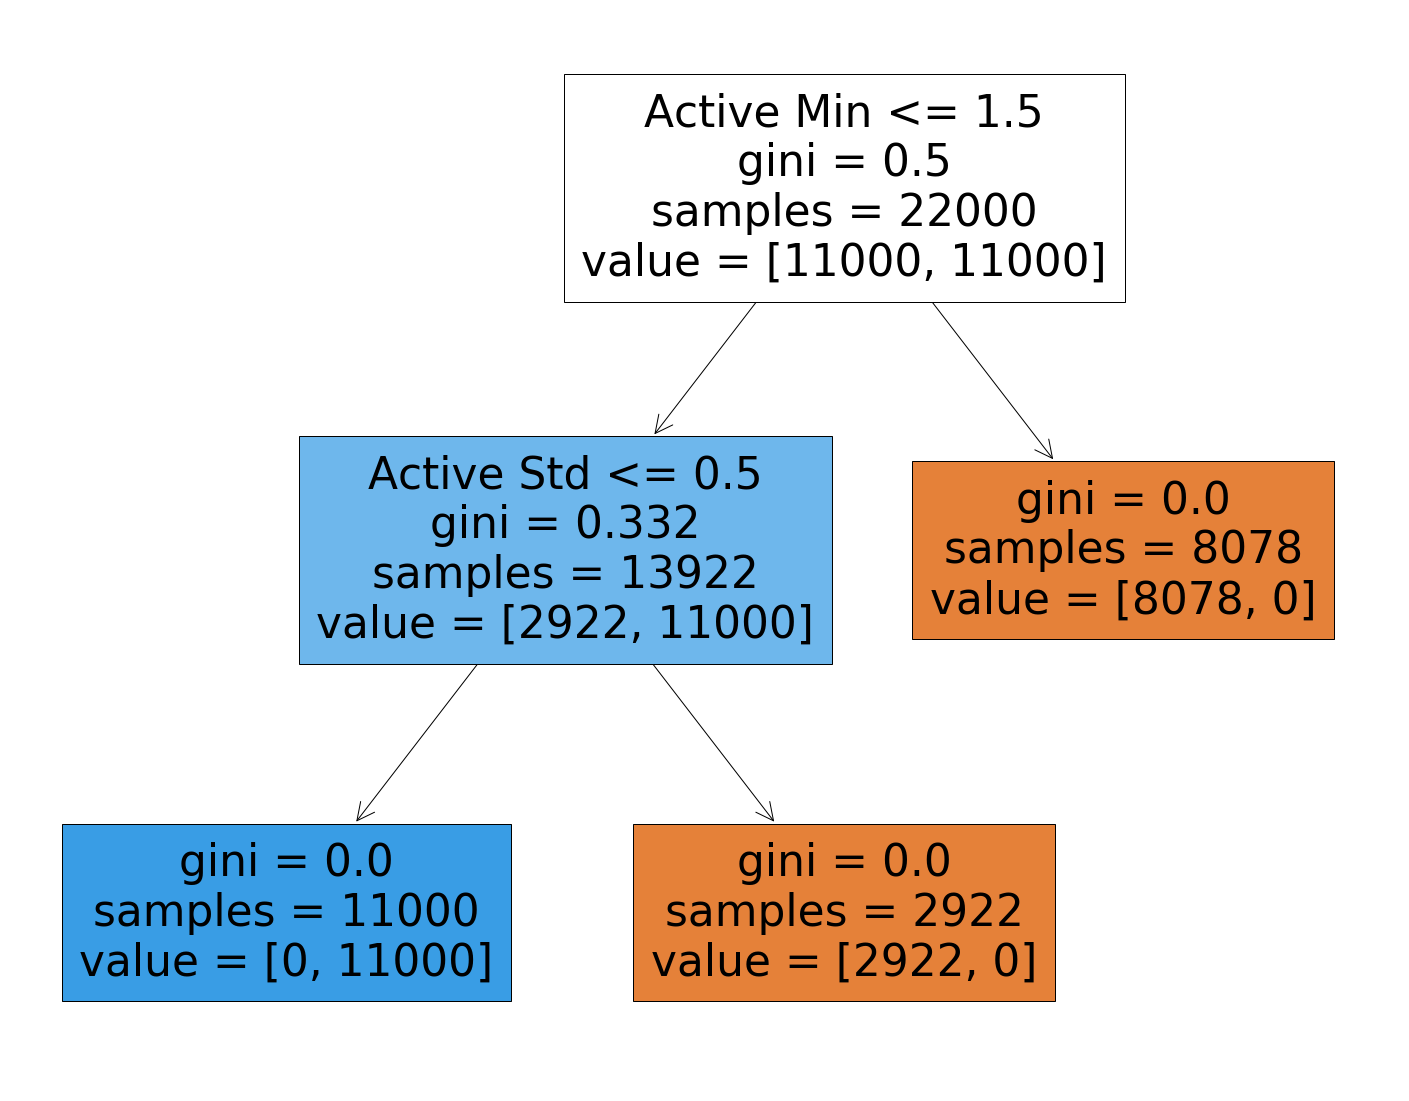

In [166]:
model = models[24]
columns = get_selected_columns(clf)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf['Class'], 
                   feature_names=columns,
                   filled=True)

In [204]:
aux = pd.read_csv("/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/original/benignos/cleaned/iotPerDeviceCleaned.csv")

In [205]:
aux[(aux["Subflow Fwd Packets"] > 1.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Cameras            NaN
Health Monitor     NaN
Energy Managment   NaN
Controller/HUBS    NaN
Appliences         NaN
Name: Device Class, dtype: float64

In [206]:
aux[(aux["Subflow Fwd Packets"] <=  1.5) & (aux["Subflow Bwd Packets"] > 0.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Cameras            NaN
Health Monitor     NaN
Energy Managment   NaN
Controller/HUBS    NaN
Appliences         NaN
Name: Device Class, dtype: float64

In [207]:
aux[(aux["Subflow Fwd Packets"] <=  1.5) & (aux["Subflow Bwd Packets"] <= 0.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Cameras             1.0
Health Monitor      1.0
Energy Managment    1.0
Controller/HUBS     1.0
Appliences          1.0
Name: Device Class, dtype: float64

# Experimento 3

In [48]:
df_3 = pd.read_csv(resul_exp_3)

df_3 = df_3[df_3["train_method"] == "Grid Search 3 folds"]
df_3 = df_3[df_3["selecao_feat"] == "Tree"]
df_3["Dados de treino/teste"] = df_3["dataset_treino"].apply(atribui_label_3)
df_3 = df_3[["algoritmo", "Dados de treino/teste", "acuracia", "precisao", "recall", "f1"]]

In [49]:
df_3.groupby(['algoritmo', 'Dados de treino/teste']).mean()[["f1", "acuracia"]].round(decimals=3).to_latex('resultado-3.table')
df_3.groupby(['algoritmo', 'Dados de treino/teste']).mean()[["f1", "acuracia"]].round(decimals=3)

,,f1,acuracia
algoritmo,Dados de treino/teste,,
Decision Trees,Benignos e Anômalos,0.962,0.962
Gaussian Naive Bayes,Benignos e Anômalos,0.641,0.639
Knn,Benignos e Anômalos,0.753,0.749
Random Forests,Benignos e Anômalos,0.964,0.963


In [18]:
def start_result_frame():
    result_frame = {
        'Experimento': []
    }
    colunas = pd.read_csv("./datasets/experimento-1/iot-mobile-nontor/05_05_05-90-train.csv").columns.values.tolist()
    colunas.sort()
    for coluna in colunas:
        result_frame[coluna] = []
    return result_frame

def get_features_selected_per_model(models, result_frame=None, experimento=0):
    if result_frame is None:
        result_frame = start_result_frame()
    for model in models:
        clf = load(model)
        sel_cols = get_selected_columns(clf)
        result_frame['Experimento'].append(experimento)
        colunas_selecionadas = get_selected_columns(clf)
        colunas_selecionadas.sort_values()
        for coluna in result_frame.keys():
            if coluna in colunas_selecionadas:
                result_frame[coluna].append(1)
            elif coluna != 'Experimento':
                result_frame[coluna].append(0)
    return result_frame

In [19]:
model_path = './models/tcc/'
model_std = 'anomaly'

gnb_models = []
knn_models = []

gnb_models += get_models(model_path + "naive-bayes/used/", model_std)
knn_models += get_models(model_path + "knn/used/", model_std)

In [20]:
gnb_models

['./models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-90-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-91-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-92-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-93-train.sck',
 './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-94-train.sck']

In [22]:
result_frame = get_features_selected_per_model(gnb_models, experimento="GNB 3")
result_frame = get_features_selected_per_model(knn_models, result_frame=result_frame, experimento="KNN 3")

aux =pd.DataFrame(result_frame)

In [23]:
aux

,Experimento,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Bwd Header Length,Bwd IAT Max,Bwd IAT Mean,...,SYN Flag Count,Src Port,Subflow Bwd Bytes,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Bwd packets,Total Fwd Packet,Total Length of Bwd Packet,Total Length of Fwd Packet
0,GNB 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,GNB 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
2,GNB 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
3,GNB 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
4,GNB 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
5,KNN 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
6,KNN 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
7,KNN 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
8,KNN 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
9,KNN 3,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0


In [27]:
aux_1 = aux[aux["Experimento"] == "GNB 3"]
aux_1[filter_cols_not_zero(aux_1)].sum().sort_values(ascending=False)

Src Port                 5
SYN Flag Count           5
Protocol                 5
PSH Flag Count           5
Fwd Seg Size Min         5
Fwd PSH Flags            5
Fwd IAT Total            5
Fwd Header Length        5
Flow Duration            5
FWD Init Win Bytes       5
FIN Flag Count           5
Dst Port                 5
Bwd Header Length        5
ACK Flag Count           5
Bwd Packet Length Max    1
dtype: int64

In [28]:
aux_1 = aux[aux["Experimento"] == "KNN 3"]
aux_1[filter_cols_not_zero(aux_1)].sum().sort_values(ascending=False)

Src Port              5
SYN Flag Count        5
Protocol              5
PSH Flag Count        5
Fwd Seg Size Min      5
Fwd PSH Flags         5
Fwd IAT Total         5
Fwd Header Length     5
FWD Init Win Bytes    5
FIN Flag Count        5
Dst Port              5
Bwd Header Length     5
ACK Flag Count        5
Flow Duration         4
Packet Length Max     1
dtype: int64

In [52]:
model_exp = './models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_anomaly_05_05_05-90-train.sck'
test_path = './datasets/experimento-extra/'
tests = [test_path + x for x in os.listdir(test_path) if "-test.csv" in x]
clf = load(model_exp)

tests.sort()

for test in tests:
    acc, f1 = get_scores(test, clf, y_function=device_class_anom_transform)
    print(acc.round(3), f1.round(3), test.split('/')[3])

0.642 0.687 anomaly_05_05_05-90-test.csv
0.643 0.688 anomaly_05_05_05-91-test.csv
0.649 0.694 anomaly_05_05_05-92-test.csv
0.651 0.694 anomaly_05_05_05-93-test.csv
0.653 0.696 anomaly_05_05_05-94-test.csv


In [69]:
train_df = './datasets/experimento-extra/anomaly_05_05_05-90-train.csv'    

dataset = CustomDataSet(train_df, train_df, test_size=0.3, y_function=device_class_anom_transform)
pipeline = ClassificationPipeline("Gaussian Naive Bayes", GaussianNB(), dataset, {}, create_scorers(), feature_selection=feature_selection, refit="precision_score")
pipeline.train_grid_search()
clf = pipeline.estimator

for test in tests:
    acc, f1 = get_scores(test, clf, y_function=device_class_anom_transform)
    print(acc.round(3), f1.round(3), test.split('/')[3])

0.586 0.674 anomaly_05_05_05-90-test.csv
0.584 0.672 anomaly_05_05_05-91-test.csv
0.588 0.676 anomaly_05_05_05-92-test.csv
0.593 0.678 anomaly_05_05_05-93-test.csv
0.589 0.675 anomaly_05_05_05-94-test.csv


# Rascunho 

In [3]:
path = 'datasets/experimento-2'
dirs = [path + "/" + diretorio for diretorio in os.listdir(path) if '.' not in diretorio] 

In [4]:
for pasta in dirs:
    train_files = [pasta + "/" + file for file in os.listdir(pasta) if "-train.csv" in file] 
    test_files  = [pasta + "/" + file for file in os.listdir(pasta) if "-test.csv" in file]
    cum_sum = 0
    n = len(train_files) * len(test_files)
    for train in train_files:
        for test in test_files:
            aux_1 = pd.read_csv(train)
            aux_2 = pd.read_csv(test)
            p1, p2, p3 = find_lines_in_common(aux_1, aux_2)
            cum_sum = p3/n
            if (p1 > 0.1) or (p2 > 0.1) or (p3 > 0.1):
                print(train.split("/")[-1], test.split("/")[-1])
                print("/t", p1, p2, p3)
    print(pasta + ":", cum_sum)

datasets/experimento-2/controller_hubs: 0.0002781818181818182
datasets/experimento-2/appliences: 0.0018781818181818183
datasets/experimento-2/cameras: 0.0007509090909090909
datasets/experimento-2/energy_managment: 0.0007000000000000001
datasets/experimento-2/health_monitor: 0.00030548231657423404


In [200]:
path = '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/'

In [203]:
algoritmo_f = path + 'decision-tree/used/'

models = [algoritmo_f + x for x in os.listdir(algoritmo_f) if "cameras" in x]
models.sort()
models

['/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-90-trains.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-91-trains.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-92-trains.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-93-trains.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-94-trains.sck']

In [204]:
tests = [
    '/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/experimento-2/appliences',
]

for model in models:
    print(model)
    files = []
    for test in tests:
        files += [test + "/" + x for x in os.listdir(test) if "-test.csv" in x]
    clf = load(model)
    files_app = [x for x in files if "05_05_05" in x]
    f1 = get_f1_scores(files_app, clf)
    print(sum(f1) / len(f1))

/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-90-trains.sck
1.0
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-91-trains.sck
1.0
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-92-trains.sck
1.0
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-93-trains.sck
1.0
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_cameras_05_05_05-94-trains.sck
1.0


In [85]:
algoritmo_f = path + 'naive-bayes/used/'

models = [algoritmo_f + x for x in os.listdir(algoritmo_f) if "tree_05" in x]
models.sort()
models

['/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-90-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-91-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-92-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-93-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-94-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-90-train.sck',
 '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naiv

In [17]:
tests = [
    '/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/experimento-1/iot-mobile-nontor',
    '/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/experimento-1/iot-mobile',
    '/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/experimento-1/iot-nontor'
]

for model in models:
    print(model)
    files = []
    for test in tests:
        files += [test + "/" + x for x in os.listdir(test) if "-test.csv" in x]
    clf = load(model)
    files_imn = [x for x in files if "05_05_05" in x]
    files_im  = [x for x in files if "05_10_00" in x]
    files_in  = [x for x in files if "05_00_10" in x]
    f1_imn = get_f1_scores(files_imn, clf)
    f1_im  = get_f1_scores(files_im, clf)
    f1_in  = get_f1_scores(files_in, clf)
    print(sum(f1_imn) / len(f1_imn))
    print(sum(f1_im) / len(f1_im))
    print(sum(f1_in) / len(f1_in))

/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-90-train.sck
0.2689218468725496
0.2605887843698754
0.2727316167453472
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-91-train.sck
0.26810299973097884
0.2595392062168236
0.2720286802114435
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-92-train.sck
0.2700420072019779
0.26192304020245594
0.2740343498647797
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-93-train.sck
0.271684915549191
0.26293752303730056
0.2759033534648521
/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-94-train.sck
0.2684321517443167
0.26340535084562

In [255]:
model = '/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/decision-tree/used/decision_trees_grid_search_3_folds_tree_appliences_05_05_05-90-trains.sck'
test = '/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/experimento-2/appliences/appliences_05_05_05-90-test.csv'
clf = load(model)
df = CustomDataSet(None, test, x_function=no_transform_x, y_function=device_class_tor_non_tor_transform)

In [256]:
sel_index = clf['FSele'].get_support()
columns = df.dataset.drop(["Device Class"], axis=1).columns[sel_index]

In [257]:
pred = clf.predict(df.x())
confusion_matrix(df.y(), pred)

array([[11000,     0],
       [    0, 11000]])

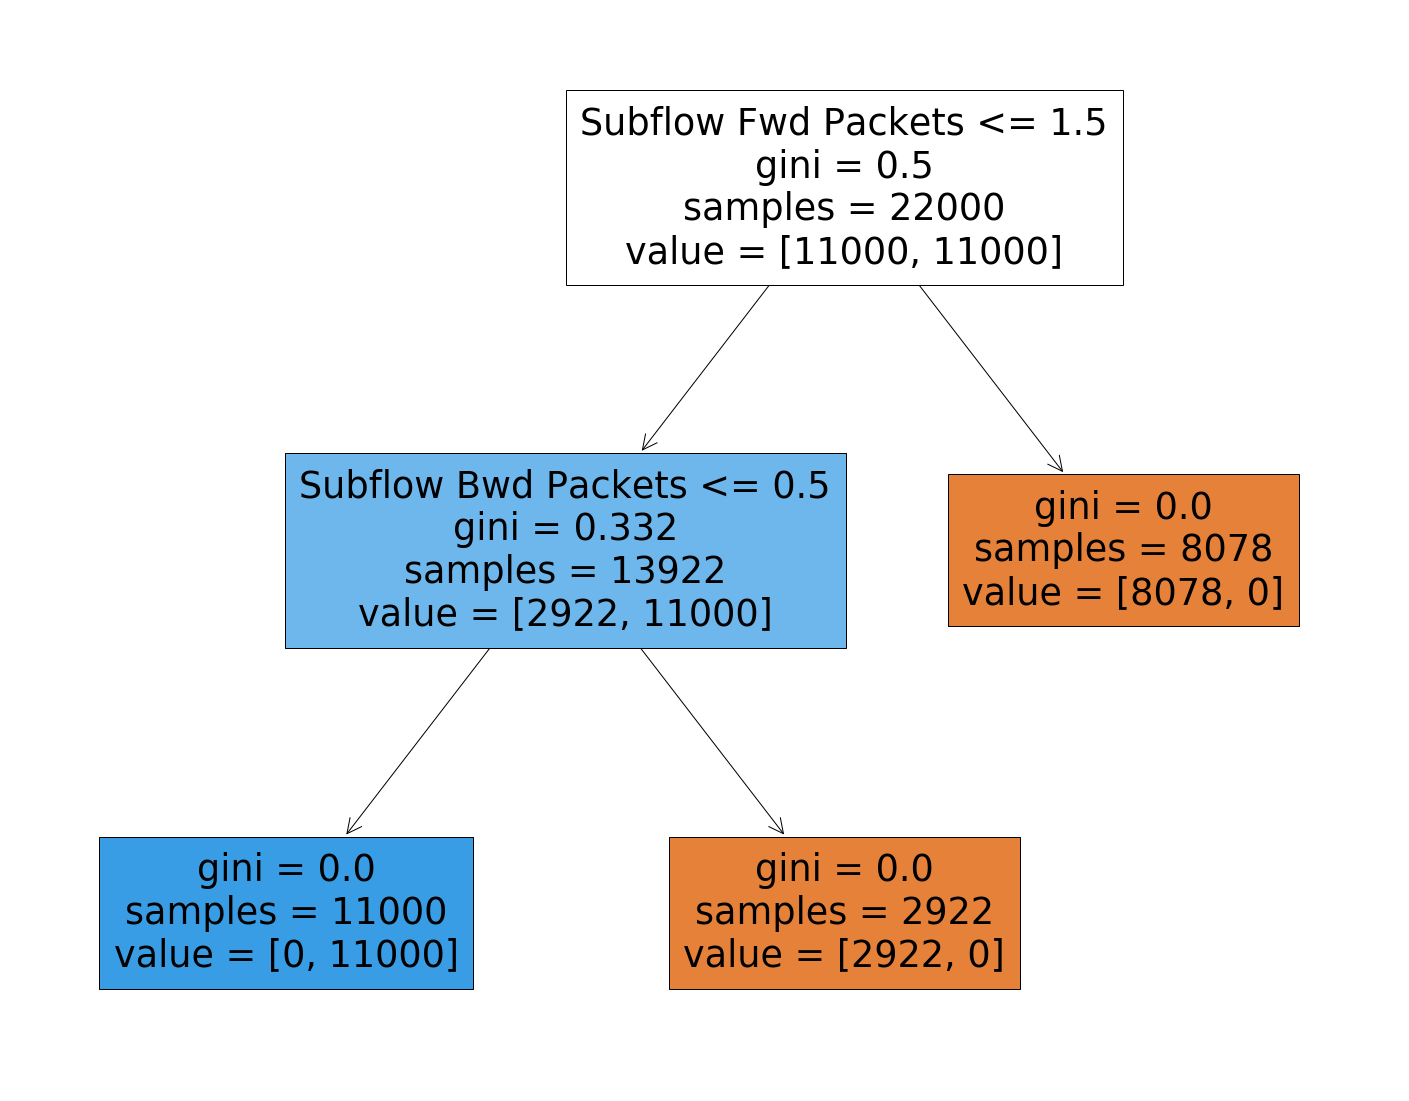

In [258]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf['Class'], 
                   feature_names=columns,
                   filled=True)

In [276]:
aux = pd.read_csv("/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/original/benignos/cleaned/dataSetCleaned.csv")

In [277]:
aux[(aux["Subflow Bwd Packets"] >  1.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Mobile     0.346917
Non Tor    0.466673
Iot        0.501748
Name: Device Class, dtype: float64

In [278]:
aux[(aux["Subflow Bwd Packets"] <= 0.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Mobile     0.286852
Non Tor    0.296223
Iot        0.240783
Name: Device Class, dtype: float64

In [279]:
aux = pd.read_csv("/home/adriano/Documentos/evaluation-of-iot-traffic/datasets/original/benignos/cleaned/iotPerDeviceCleaned.csv")

In [280]:
aux[(aux["Subflow Bwd Packets"] >  1.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Cameras            NaN
Health Monitor     NaN
Energy Managment   NaN
Controller/HUBS    NaN
Appliences         NaN
Name: Device Class, dtype: float64

In [281]:
aux[(aux["Subflow Bwd Packets"] <= 0.5)]["Device Class"].value_counts() / aux["Device Class"].value_counts()

Cameras             1.0
Health Monitor      1.0
Energy Managment    1.0
Controller/HUBS     1.0
Appliences          1.0
Name: Device Class, dtype: float64

In [268]:
aux[aux["Subflow Bwd Packets"] > 1.5]["Device Class"].value_counts()

Mobile     395603
Non Tor    386616
Iot         55390
Name: Device Class, dtype: int64

In [273]:
aux[(aux["Subflow Bwd Packets"] <= 1.5) & (aux["Subflow Bwd Packets"] > 0.5)]["Device Class"].value_counts()

Mobile     417627
Non Tor    196429
Iot         28423
Name: Device Class, dtype: int64

In [274]:
aux[(aux["Subflow Bwd Packets"] <= 0.5)]["Device Class"].value_counts()

Mobile     327108
Non Tor    245406
Iot         26581
Name: Device Class, dtype: int64

In [26]:
model_1 = "/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_05_05-90-train.sck"
model_2 = "/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_10_00-90-train.sck"
model_3 = "/home/adriano/Documentos/evaluation-of-iot-traffic/models/tcc/naive-bayes/used/gaussian_naive_bayes_grid_search_3_folds_tree_05_00_10-90-train.sck"

test_1 = files_imn[0]
test_2 = files_im[0]
test_3 = files_in[0]

clf_1 = load(model_1)
clf_2 = load(model_2)
clf_3 = load(model_3)

df_1 = CustomDataSet(None, test_1, x_function=no_transform_x, y_function=device_class_tor_non_tor_transform)
df_2 = CustomDataSet(None, test_2, x_function=no_transform_x, y_function=device_class_tor_non_tor_transform)
df_3 = CustomDataSet(None, test_3, x_function=no_transform_x, y_function=device_class_tor_non_tor_transform)

## Iot 1, Non Iot 0

In [67]:
pred = clf_1.predict(df_2.x())
tn, fp, fn, tp = confusion_matrix(df_3.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 2726
True Negative 10322
False Positive 678
False Negative 8274


In [68]:
pred = clf_1.predict(df_3.x())
tn, fp, fn, tp = confusion_matrix(df_3.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 2768
True Negative 10701
False Positive 299
False Negative 8232


In [69]:
pred = clf_2.predict(df_2.x())
tn, fp, fn, tp = confusion_matrix(df_2.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 6007
True Negative 9149
False Positive 1851
False Negative 4993


In [70]:
pred = clf_2.predict(df_3.x())
tn, fp, fn, tp = confusion_matrix(df_3.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 5945
True Negative 5119
False Positive 5881
False Negative 5055


In [71]:
pred = clf_3.predict(df_2.x())
tn, fp, fn, tp = confusion_matrix(df_2.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 1771
True Negative 10318
False Positive 682
False Negative 9229


In [72]:
pred = clf_3.predict(df_3.x())
tn, fp, fn, tp = confusion_matrix(df_3.y(), pred).ravel()
print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 1854
True Negative 10822
False Positive 178
False Negative 9146


In [11]:
import os
import pandas as pd

def quantidade_trafego_exp_3(file):
    df   = pd.read_csv(path + "/" + file)
    anom = df[df['Device Class'].apply(lambda x: "Anomaly" in x)].shape[0]
    beng = df[df['Device Class'].apply(lambda x: "Anomaly" not in x)].shape[0]
    return [anom, beng]
    
path  = './datasets/experimento-2'
dirs  = [x for x in os.listdir(path) if ".csv" not in x]
files = []
for path_dir in dirs:
    files += [path_dir + "/" + x for x in os.listdir(path + "/" + path_dir) if ".csv" in x]

files.sort()
    
for file in files:
    print("\t", file)
    df = pd.read_csv(path + "/" + file)
    print(df["Device Class"].value_counts())
    #a, b = quantidade_trafego_exp_3(file)
    #print("\t anomaly:", a)
    #print("\t benign:", b)

	 appliences/appliences_05_05_05-90-test.csv
Appliences    11000
Mobile         5500
Non Tor        5500
Name: Device Class, dtype: int64
	 appliences/appliences_05_05_05-90-train.csv
Mobile              5500
Non Tor             5500
Health Monitor      2750
Energy Managment    2750
Controller/HUBS     2750
Cameras             2750
Name: Device Class, dtype: int64
	 appliences/appliences_05_05_05-91-test.csv
Appliences    11000
Mobile         5500
Non Tor        5500
Name: Device Class, dtype: int64
	 appliences/appliences_05_05_05-91-train.csv
Mobile              5500
Non Tor             5500
Health Monitor      2750
Energy Managment    2750
Controller/HUBS     2750
Cameras             2750
Name: Device Class, dtype: int64
	 appliences/appliences_05_05_05-92-test.csv
Appliences    11000
Mobile         5500
Non Tor        5500
Name: Device Class, dtype: int64
	 appliences/appliences_05_05_05-92-train.csv
Mobile              5500
Non Tor             5500
Health Monitor      2750
Energy 

In [2]:
path = './datasets/original/benignos/cleaned/'

aux1 = pd.read_csv(path + 'dataSetCleaned.csv')
aux2 = pd.read_csv(path + 'iotPerDeviceCleaned.csv')

In [3]:
aux1['Device Class'].value_counts()

Mobile     1140338
Non Tor     828451
Iot         110394
Name: Device Class, dtype: int64

In [4]:
aux2.shape

(1043613, 71)

In [15]:
import pandas as pd

In [16]:
exp1 = './resultados/experimento-1/tcc/resultado_experimento_1-90-14-05-2021.csv'
exp2 = './resultados/experimento-2/tcc/resultado_experimento_2-90-14-05-2021.csv'
exp3 = './resultados/experimento-extra/tcc/resultado_experimento_extra-90-14-05-2021.csv'

In [17]:
df = pd.read_csv(exp1)
df = df[(df["train_method"] == "Grid Search 3 folds") & (df["selecao_feat"] == "Tree")]
df.iloc[:, 1:][["algoritmo", "dataset_treino", "dataset_test", "acuracia", "f1"]].to_latex('res-exp-1.tex', index=False)

In [18]:
df = pd.read_csv(exp2)
df = df[(df["train_method"] == "Grid Search 3 folds") & (df["selecao_feat"] == "Tree")]
df.iloc[:, 1:][["algoritmo", "dataset_treino", "dataset_test", "acuracia", "f1"]].to_latex('res-exp-2.tex', index=False)

In [19]:
df = pd.read_csv(exp3)
df = df[(df["train_method"] == "Grid Search 3 folds") & (df["selecao_feat"] == "Tree")]
df.iloc[:, 1:][["algoritmo", "dataset_treino", "dataset_test", "acuracia", "f1"]].to_latex('res-exp-3.tex', index=False)